In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

In [3]:
weight = 0.7
bias = 0.3

start = 0
step = 0.02
end = 1

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

In [5]:
training = int(0.8 * len(X))
X_train, y_train = X[:training], y[:training]
X_test, y_test = X[training:], y[training:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

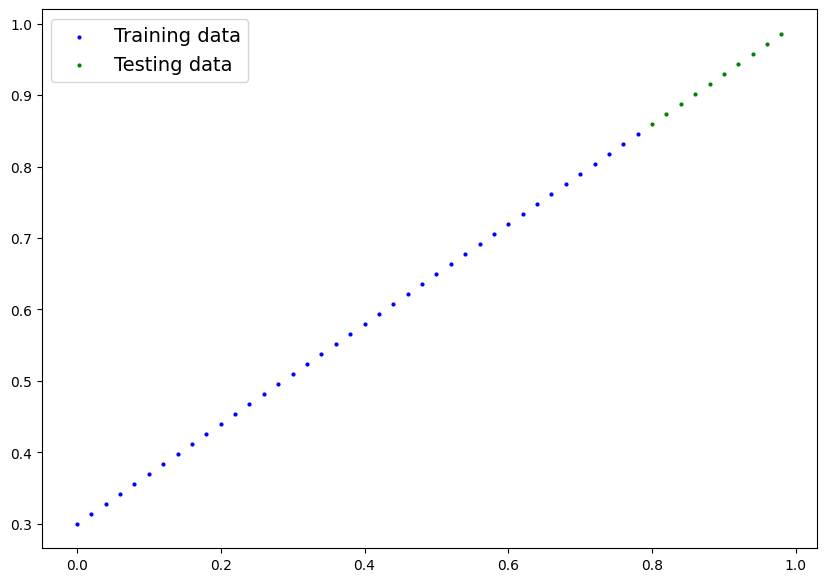

In [29]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});


plot_predictions()

## Build a model

In [48]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias



In [49]:
torch.manual_seed(42)

model0 = LinearRegressionModel()

list(model0.parameters())
model0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [50]:
with torch.inference_mode():
  y_preds = model0(X_test)

print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


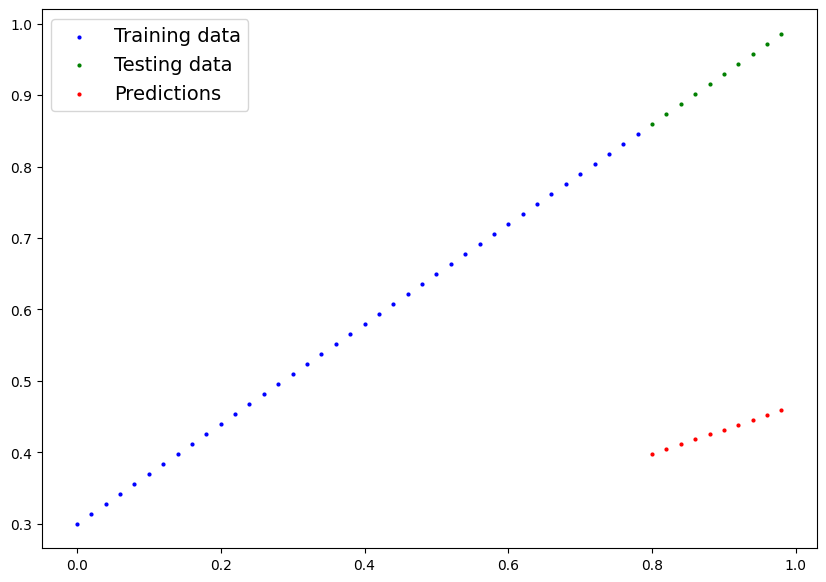

In [51]:
plot_predictions(predictions=y_preds)

## Train model

In [15]:
# MDA for loss function and SGD for optimizer

In [52]:
loss_function = nn.L1Loss() # this is MAE
optimizer = torch.optim.SGD(params=model0.parameters(), # parameters of target model to optimize
                            lr=0.001) # learning rate

### Training loop and testing loop

In [53]:
torch.manual_seed(42)
epochs = 1000 # pass through the data 100 times

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

  model0.train() #set it to training mode
  y_pred = model0(X_train) #perform  the forward pass on the training data
  loss = loss_function(y_pred, y_train) #calculate the loss
  optimizer.zero_grad() #has to be reset to zero
  loss.backward()
  optimizer.step()

  # Testing
  model0.eval()

  with torch.inference_mode():
    test_pred = model0(X_test)
    test_loss = loss_function(test_pred, y_test.type(torch.float))


  if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.4931890368461609 
Epoch: 10 | MAE Train Loss: 0.3013603389263153 | MAE Test Loss: 0.4797181189060211 
Epoch: 20 | MAE Train Loss: 0.28983938694000244 | MAE Test Loss: 0.4662471413612366 
Epoch: 30 | MAE Train Loss: 0.2783183455467224 | MAE Test Loss: 0.4527761936187744 
Epoch: 40 | MAE Train Loss: 0.26679736375808716 | MAE Test Loss: 0.43930521607398987 
Epoch: 50 | MAE Train Loss: 0.2552763819694519 | MAE Test Loss: 0.4258342385292053 
Epoch: 60 | MAE Train Loss: 0.24375538527965546 | MAE Test Loss: 0.41236335039138794 
Epoch: 70 | MAE Train Loss: 0.232234388589859 | MAE Test Loss: 0.398892343044281 
Epoch: 80 | MAE Train Loss: 0.22071340680122375 | MAE Test Loss: 0.38542139530181885 
Epoch: 90 | MAE Train Loss: 0.2091923952102661 | MAE Test Loss: 0.3719504475593567 
Epoch: 100 | MAE Train Loss: 0.19767141342163086 | MAE Test Loss: 0.35847947001457214 
Epoch: 110 | MAE Train Loss: 0.18615040183067322 | MAE Test Loss: 0.

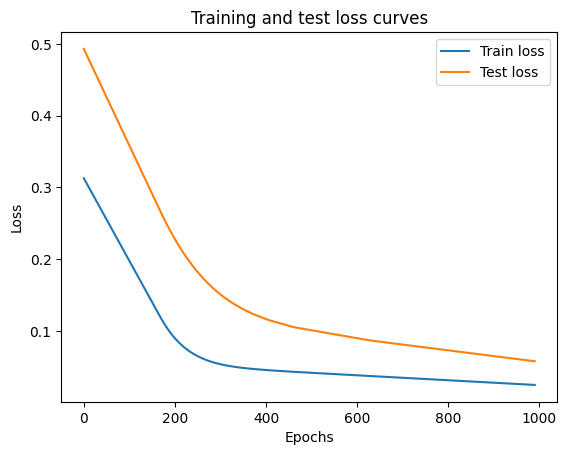

In [54]:
# PLot the loss
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [55]:
# Print the learned parameters
print(model0.state_dict())

OrderedDict([('weights', tensor([0.5788])), ('bias', tensor([0.3509]))])


## Make predictions with the model (inference)

In [57]:
# put the model into eval mode
model0.eval()

with torch.inference_mode():
  y_preds = model0(X_test)

y_preds

tensor([[0.8140],
        [0.8255],
        [0.8371],
        [0.8487],
        [0.8603],
        [0.8718],
        [0.8834],
        [0.8950],
        [0.9066],
        [0.9181]])

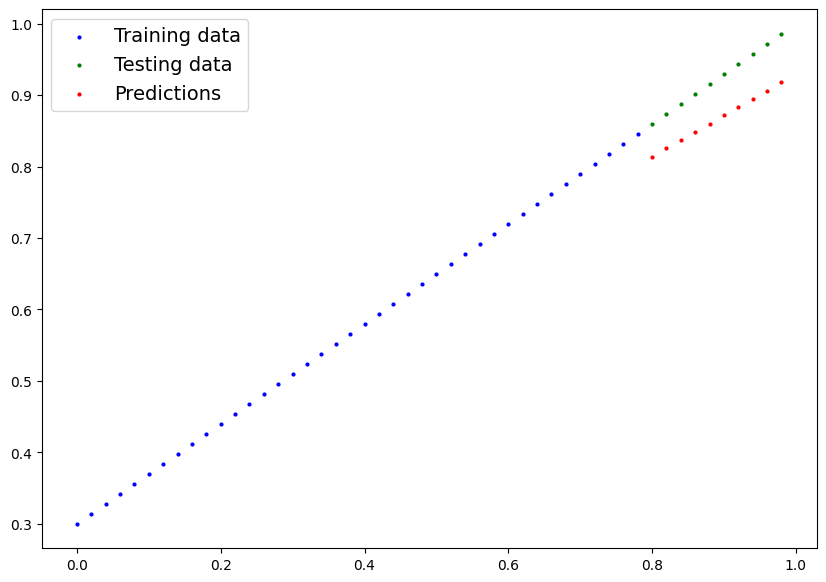

In [58]:
plot_predictions(predictions=y_preds)

## Save and load a model

In [60]:
# we save or load a model's state_dict object
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "BASIC_NN_MODEL.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/BASIC_NN_MODEL.pth


In [61]:
# Create a model with loaded parameters
loaded_model0 = LinearRegressionModel()
loaded_model0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>